# Testing batdetect2 pipeline features:

## **Working on features relevant to the use of this pipeline on recovered Audiomoth .wav recordings**

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer

In [5]:
ubna_01_df = pd.read_csv('../output_dir/ubna_data_01_collected_audio_records.csv', dtype=str, index_col=0)
ubna_02_df = pd.read_csv('../output_dir/ubna_data_02_collected_audio_records.csv', dtype=str, index_col=0)
pd.to_datetime(ubna_02_df['Datetime UTC']).dt.time.astype('str')

0        00:45:21
1        01:00:00
2        01:30:00
3        02:00:00
4        02:30:00
           ...   
70650    11:00:00
70651    11:30:00
70652    12:00:00
70653    12:30:00
70654    13:00:00
Name: Datetime UTC, Length: 70655, dtype: object

In [26]:
cfg = dict()
cfg["input_dir"] = f'{Path.home()}/Documents/Research/Symposium/Recordings'
cfg["output_dir"] = Path("../output_dir")
cfg["csv_name"] = "wav_files_test_record.csv"
cfg["hard_drive"] = 'ubna_data_01'

In [30]:
hard_drive_df = pd.read_csv(f'../output_dir/{cfg["hard_drive"]}_collected_audio_records.csv', dtype=str, index_col=0)
hard_drive_df["Datetime UTC"] = pd.DatetimeIndex(hard_drive_df["Datetime UTC"])
hard_drive_df.set_index("Datetime UTC", inplace=True)

site_name = 'Foliage'
data_params = dict()
data_params['site'] = site_name

site_name_cond = hard_drive_df["Site name"] == site_name

file_year_cond = hard_drive_df.index.year == 2022
minute_cond = np.logical_or((hard_drive_df.index).minute == 30, (hard_drive_df.index).minute == 0)
datetime_cond = np.logical_and((hard_drive_df.index).second == 0, minute_cond)
file_error_cond = np.logical_and((hard_drive_df["File duration"]!='File has no comment due to error!'), (hard_drive_df["File duration"]!='File has no Audiomoth-related comment'))
all_errors_cond = np.logical_and((hard_drive_df["File duration"]!='Is empty!'), file_error_cond)

filtered_location_df = hard_drive_df.loc[site_name_cond&datetime_cond&file_year_cond&all_errors_cond].sort_index()
filtered_location_nightly_df = filtered_location_df.between_time('03:00', '13:30', inclusive="left")

data_params['output_dir'] = cfg["output_dir"] / data_params["site"]
print(f"Will save csv file to {data_params['output_dir']}")

Will save csv file to ../output_dir/Foliage


In [31]:
data_params['ref_audio_files'] = filtered_location_nightly_df["File path"].apply(lambda x : Path(x)).values
file_status_cond = filtered_location_nightly_df["File status"] == "Usable for detection"
file_duration_cond = np.isclose(filtered_location_nightly_df["File duration"].astype('float'), 1795)
good_deploy_session_df = filtered_location_nightly_df.loc[file_status_cond&file_duration_cond]
data_params['good_audio_files'] = good_deploy_session_df["File path"].apply(lambda x : Path(x)).values
data_params['recover_folder'] = good_deploy_session_df["Recover folder"].values
data_params['audiomoth_folder'] = good_deploy_session_df["SD card #"].values

In [38]:
if list(data_params['good_audio_files']) == list(data_params['ref_audio_files']):
    print("All files from deployment session good!")
else:
    print("Error files exist!")

Error files exist!


In [11]:
with exiftool.ExifToolHelper() as et:
    print(et.get_metadata(glob.glob(f'{cfg["input_dir"]}/**/*.WAV', recursive=True)[0]))

[{'SourceFile': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220822/UBNA_001/20220820_033000.WAV', 'ExifTool:ExifToolVersion': 12.63, 'File:FileName': '20220820_033000.WAV', 'File:Directory': '/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220822/UBNA_001', 'File:FileSize': 689280488, 'File:FileModifyDate': '2023:05:04 13:13:27-07:00', 'File:FileAccessDate': '2023:05:04 13:13:27-07:00', 'File:FileInodeChangeDate': '2023:05:04 18:16:23-07:00', 'File:FilePermissions': 100644, 'File:FileType': 'WAV', 'File:FileTypeExtension': 'WAV', 'File:MIMEType': 'audio/x-wav', 'RIFF:Encoding': 1, 'RIFF:NumChannels': 1, 'RIFF:SampleRate': 192000, 'RIFF:AvgBytesPerSec': 384000, 'RIFF:BitsPerSample': 16, 'RIFF:Comment': 'Recorded at 03:30:00 20/08/2022 (UTC) by AudioMoth 24F3190361CBE990 at medium gain while battery was 4.0V and temperature was 29.1C.', 'RIFF:Artist': 'AudioMoth 24F3190361CBE990', 'Composite:Duration': 1795.00127083333}]


In [12]:
batdetect2_predictions = pd.read_csv('../output_dir/recover-20230809/E18 Bridge/bd2__recover-20230809_UBNA_015.csv')
input_files = sorted(glob.glob('../../Documents/recover-20230809/UBNA_015/*.WAV', recursive=True))
plot_file = input_files[16]
file_dt = dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
batdetect2_predictions.loc[pd.to_datetime(batdetect2_predictions['input_file'], format="%Y%m%d_%H%M%S", exact=False) == file_dt]

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Recover Folder,SD Card,Site name
3341,478.3555,478.3647,26328.0,33930.0,Echolocation,Eptesicus serotinus,0.300,0.530,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3342,478.4915,478.5009,26328.0,34460.0,Echolocation,Eptesicus serotinus,0.306,0.626,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3343,478.7275,478.7385,25468.0,34201.0,Echolocation,Nyctalus leisleri,0.389,0.703,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3344,478.9695,478.9816,25468.0,35930.0,Echolocation,Eptesicus serotinus,0.382,0.608,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
3345,479.2135,479.2286,24609.0,33170.0,Echolocation,Nyctalus leisleri,0.269,0.579,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4011,955.9255,955.9335,41796.0,63344.0,Echolocation,Pipistrellus nathusii,0.445,0.545,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4012,956.0185,956.0273,40937.0,63306.0,Echolocation,Pipistrellus nathusii,0.464,0.588,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4013,956.1145,956.1211,40937.0,55659.0,Echolocation,Pipistrellus nathusii,0.446,0.546,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge
4014,956.4005,956.4116,40937.0,61696.0,Echolocation,Pipistrellus nathusii,0.408,0.513,-1,/mnt/ubna_data_02/recover-20230809/UBNA_015/20...,recover-20230809,UBNA_015,E18 Bridge


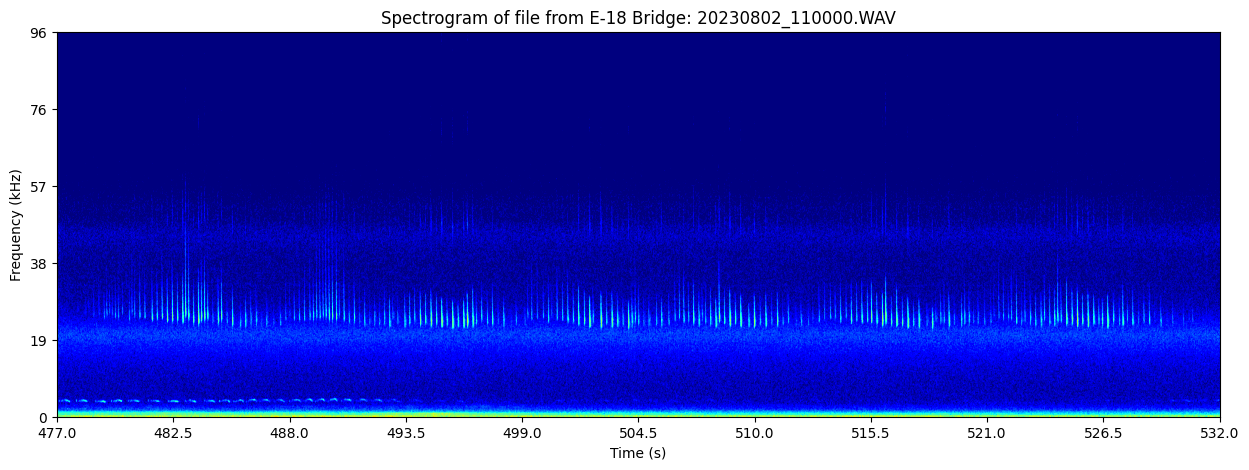

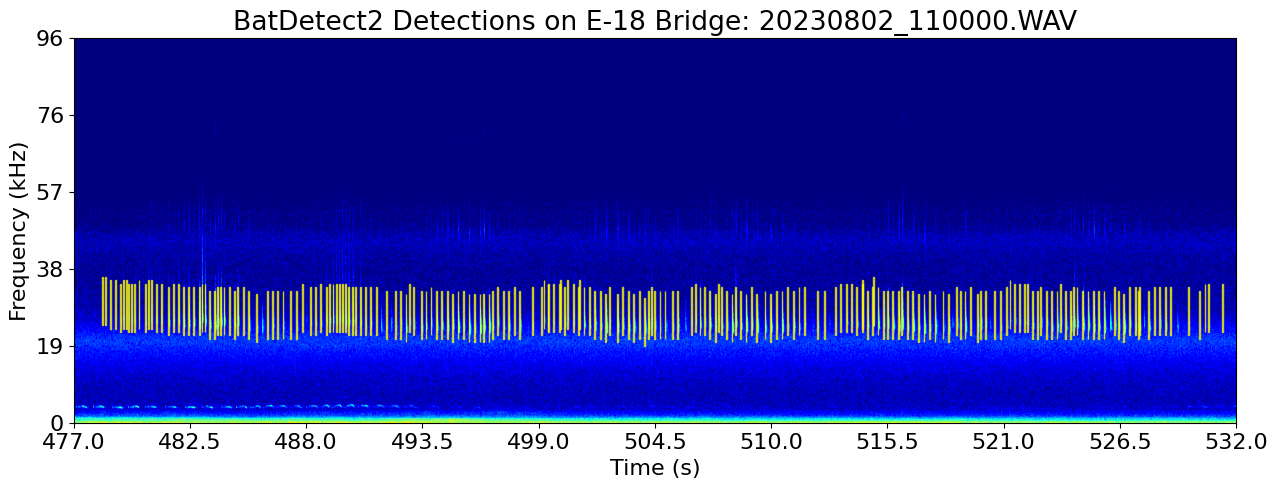

In [13]:
plot_file = input_files[16]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 477
duration = 55
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB

plt.figure(figsize=(15, 5))
plt.title(f"Spectrogram of file from E-18 Bridge: {Path(plot_file).name}")
plt.rcParams.update({'font.size': 16})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)
plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")

plt.figure(figsize=(15, 5))
plt.title(f"BatDetect2 Detections on E-18 Bridge: {Path(plot_file).name}")
plt.rcParams.update({'font.size': 16})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)
window_cond = np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))
file_cond = pd.to_datetime(batdetect2_predictions['input_file'], format="%Y%m%d_%H%M%S", exact=False) == dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
plot_dets = batdetect2_predictions.loc[np.logical_and(file_cond, window_cond)]

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()

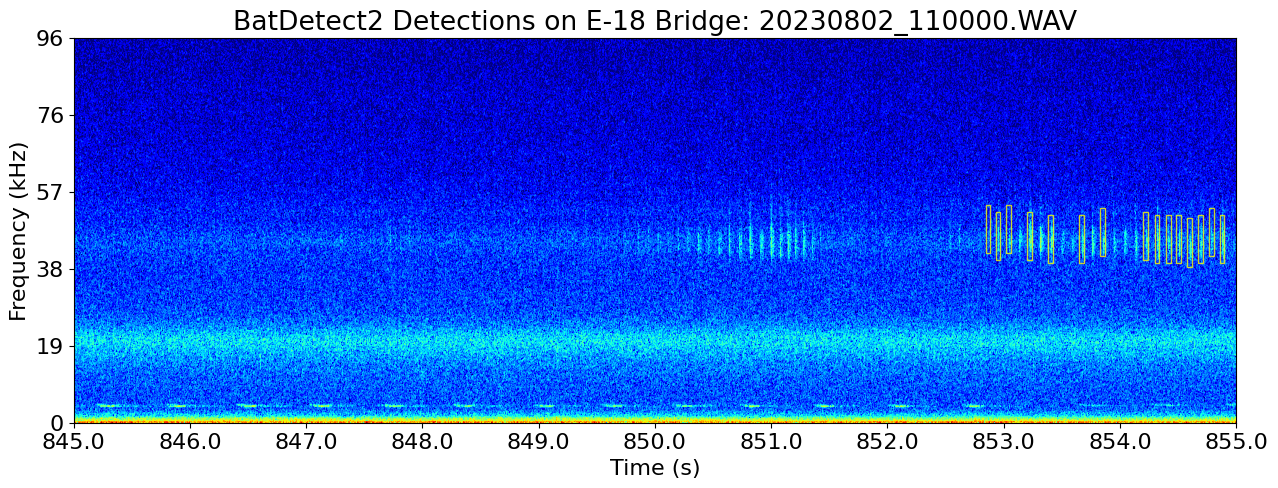

In [14]:
plot_file = input_files[16]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 845
duration = 10
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 40 # hide anything below -rm_dB dB

plt.figure(figsize=(15, 5))
plt.title(f"BatDetect2 Detections on E-18 Bridge: {Path(plot_file).name}")
plt.rcParams.update({'font.size': 16})
plt.specgram(audio_seg, NFFT=1024, cmap='jet', vmin=vmin)
window_cond = np.logical_and(batdetect2_predictions['start_time'] > start, batdetect2_predictions['end_time'] < (start+duration))
file_cond = pd.to_datetime(batdetect2_predictions['input_file'], format="%Y%m%d_%H%M%S", exact=False) == dt.datetime.strptime(Path(plot_file).name, "%Y%m%d_%H%M%S.WAV")
plot_dets = batdetect2_predictions.loc[np.logical_and(file_cond, window_cond)]

ax = plt.gca()
for i, row in plot_dets.iterrows():
    rect = patches.Rectangle(((row['start_time'] - start - 0.01)*(fs/2), (row['low_freq']-2000)/(fs/2)), 
                    0.04*(fs/2), 12000/(fs/2), linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2))
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()

## 2) Initializing our required variables:

### a) Below we initialize our input/output directories and output pipeline csv name

In [15]:
dirpath = f"{Path.home()}/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010"

recover_folder = dirpath.split('/')[-2]
recover_date = recover_folder.split('-')[1]
audiomoth_folder = dirpath.split('/')[-1]
audiomoth_unit = audiomoth_folder.split('_')[-1]

### b) Below we initialize our field records depending on what year our data is from to gather the site name

In [16]:
site_name = file_dealer.get_site_name(recover_date, audiomoth_unit)
site_name

'Central Pond'

In [17]:
save_dir = f'../output_dir/{recover_folder}/{site_name}'
detfile_name = f'bd2__{recover_folder}_{audiomoth_folder}'

[dirpath, save_dir, detfile_name]

['/Users/adityakrishna/Documents/Research/Symposium/Recordings/recover-20220828/UBNA_010',
 '../output_dir/recover-20220828/Central Pond',
 'bd2__recover-20220828_UBNA_010']

## 3) Test any main pipeline functions using the initialized variables

### a) Below we test-run our pipeline using the main `run_pipeline()` command in `src/batdt2_pipeline.py`

In [18]:
# batdetect2_pipeline.run_pipeline(dirpath, f"{detfile_name}.csv", save_dir, "../output/tmp", True, False)

### b) Below is the function that will be used in our pipeline to plot the activity plots; Use it to test the overall function

In [19]:
# batdetect2_pipeline.plot_dets_as_activity_grid(dirpath, f"{detfile_name}.csv", save_dir, site_name, show_PST=True, save=False)

## 4) Develop any of the main functions below:

### a) Using `dask.dataframe` to concatenate all generated detections into 1 large `pandas.dataframe`.

In [20]:
new_df = dd.read_csv(f"../output_dir/recover-2023*/Telephone Field/bd2__*.csv").compute()
new_df

,start_time,end_time,low_freq,high_freq,detection_confidence,event,input_file,class,class_prob,det_prob,individual,Recover Folder,SD Card,Site name
0,162.4855,162.4921,46953.0,56985.0,0.632,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,164.9085,164.9138,44375.0,52060.0,0.528,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,168.0525,168.0585,46953.0,57225.0,0.598,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,168.9195,168.9253,47812.0,58804.0,0.581,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,169.3145,169.3201,46953.0,57417.0,0.629,Echolocation,20230531_043000.WAV,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12134,1266.3215,1266.3315,42656.0,60657.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.480,0.595,-1.0,recover-20230815,UBNA_012,Telephone Field
12135,1266.4115,1266.4166,41796.0,60064.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.520,0.580,-1.0,recover-20230815,UBNA_012,Telephone Field
12136,1266.5005,1266.5071,43515.0,58077.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.561,0.643,-1.0,recover-20230815,UBNA_012,Telephone Field
12137,1266.6815,1266.6929,45234.0,54740.0,NaN,Echolocation,/mnt/ubna_data_02/recover-20230815/UBNA_012/20...,Pipistrellus pipistrellus,0.439,0.536,-1.0,recover-20230815,UBNA_012,Telephone Field


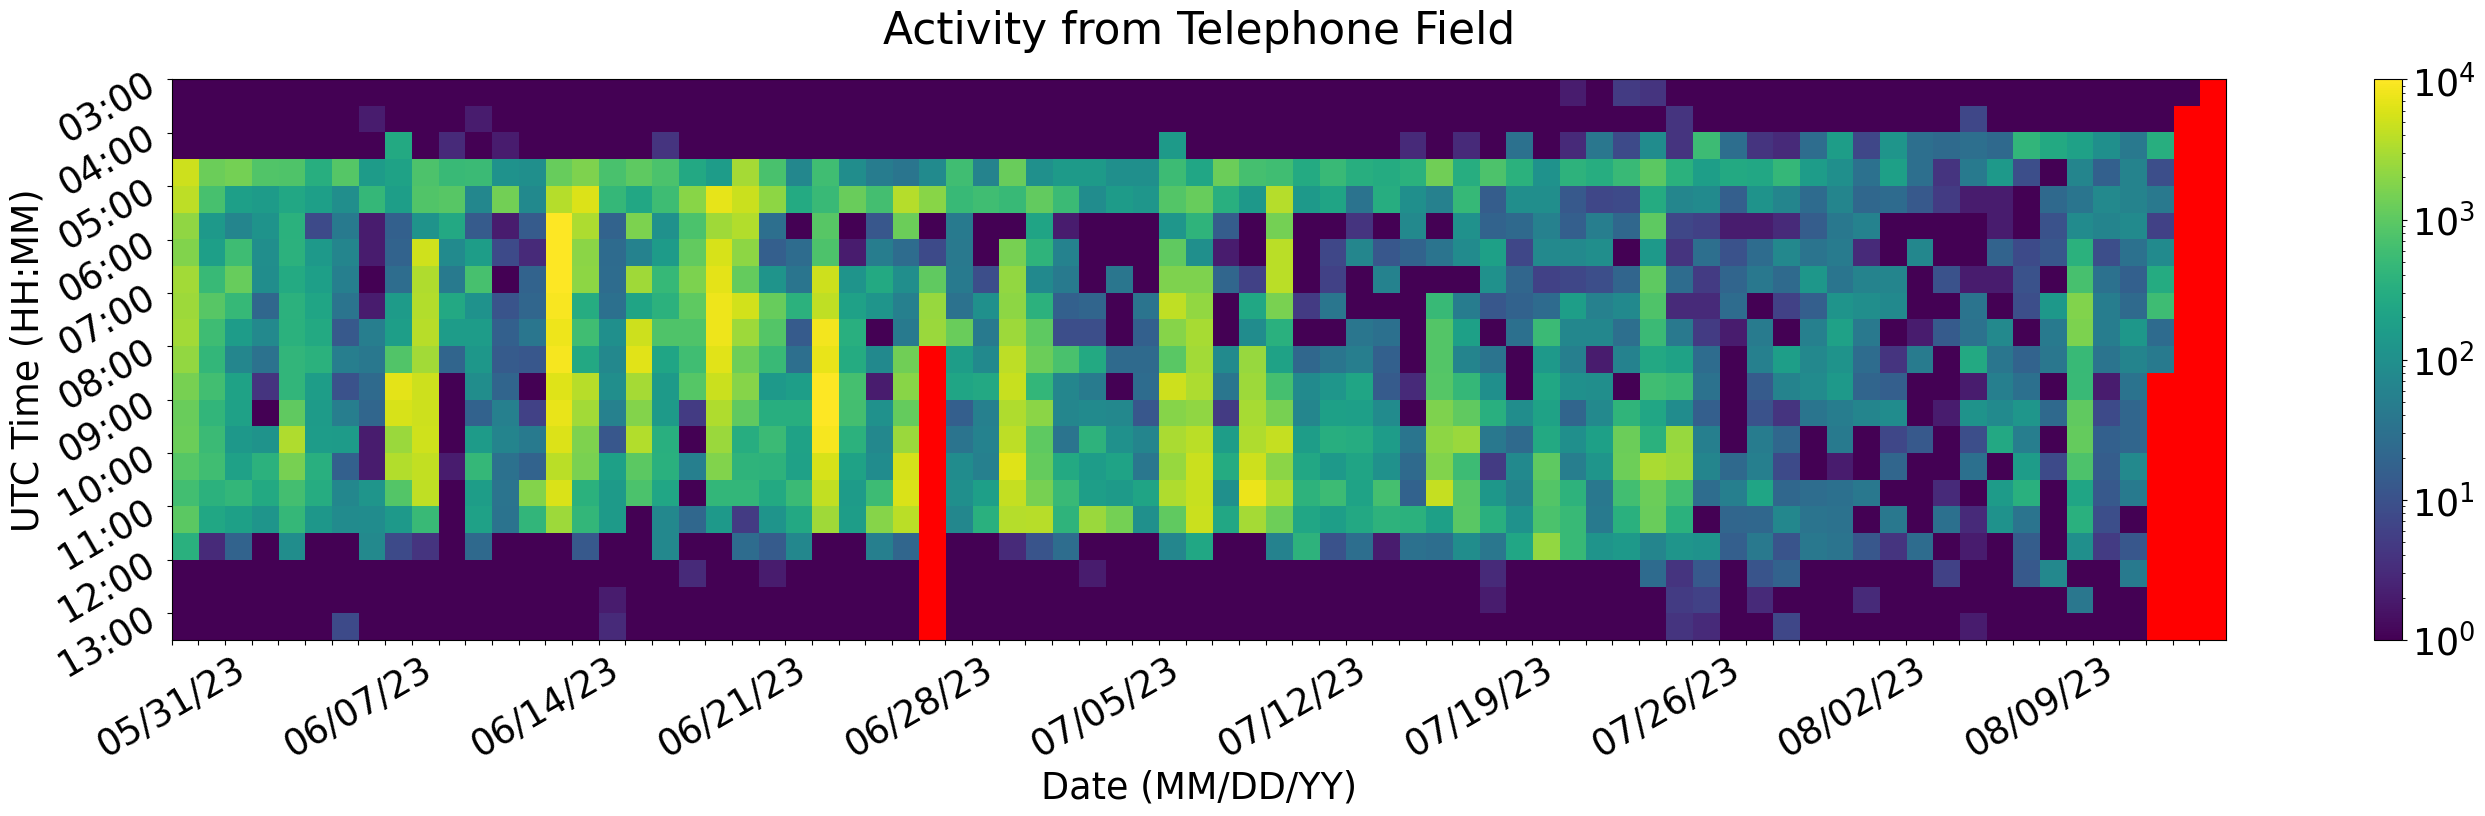

In [21]:
site = "Telephone Field"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

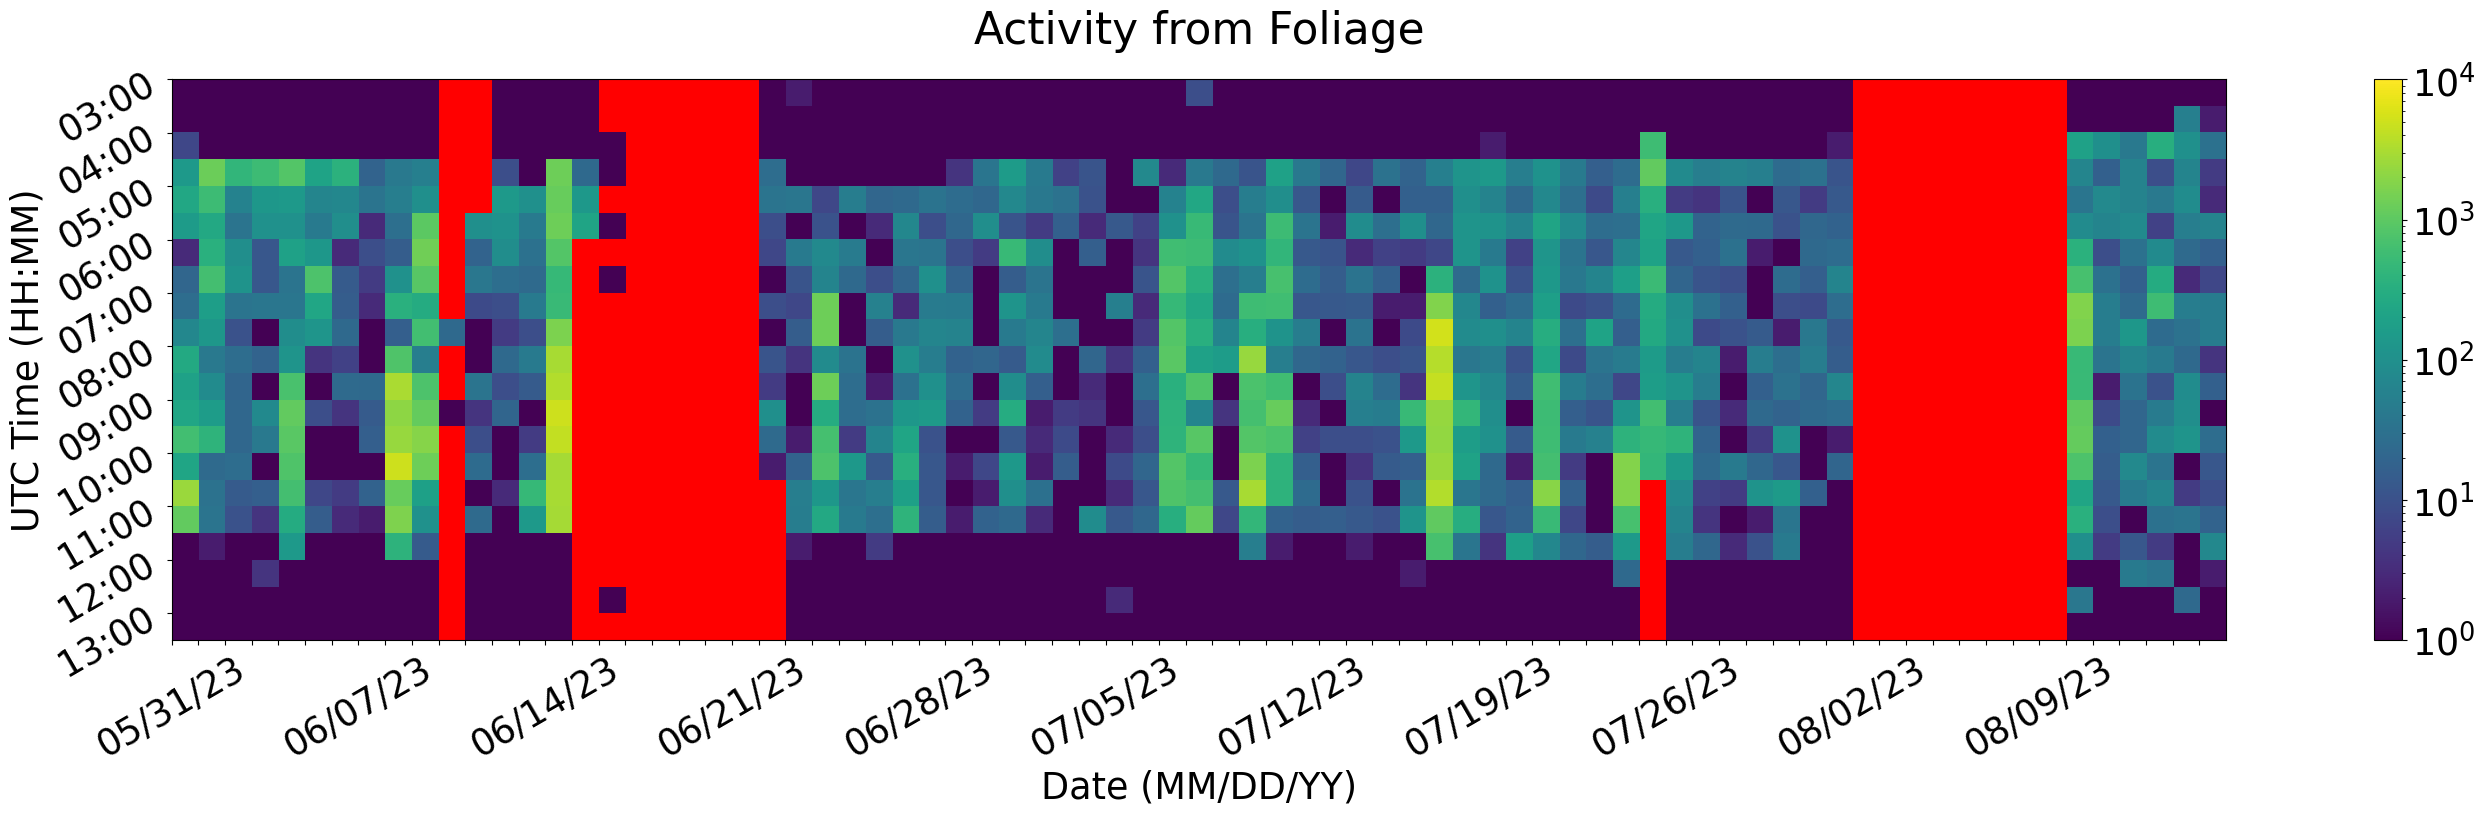

In [22]:
site = "Foliage"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)

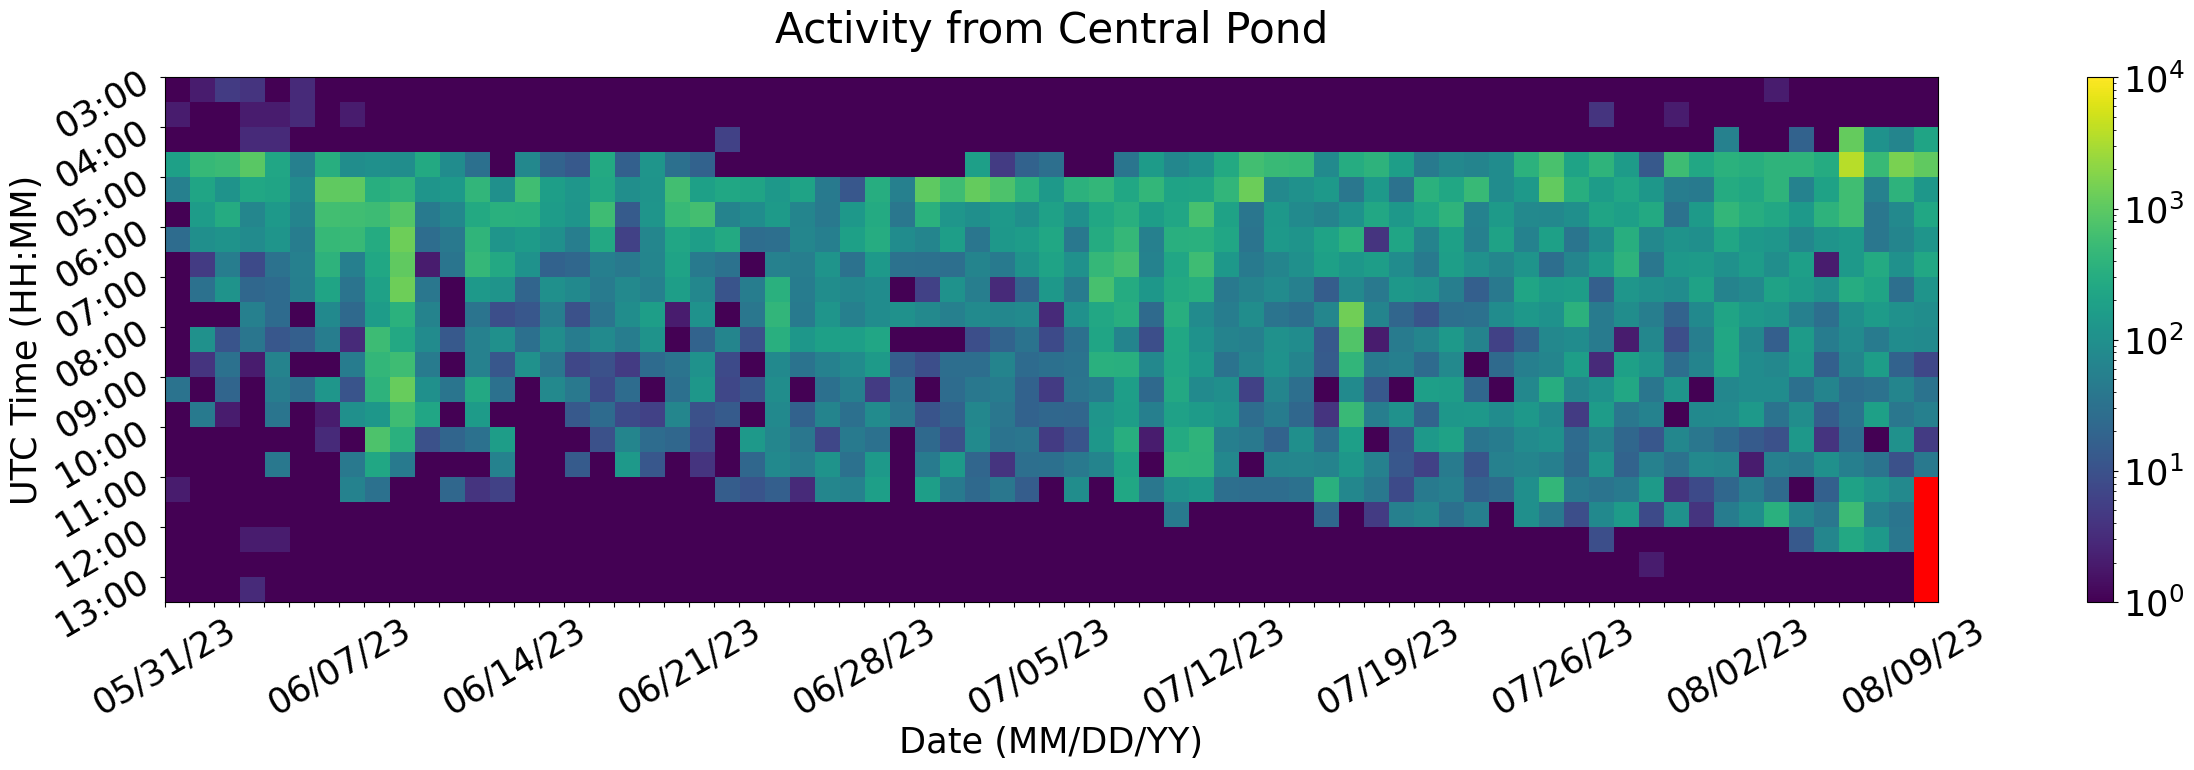

In [23]:
site = "Central Pond"
cfg["site"] = site
resample_tag = "30T"

activity_df = batdetect2_pipeline.construct_cumulative_activity(cfg['site'], resample_tag)
batdetect2_pipeline.plot_cumulative_activity(activity_df, cfg['site'], resample_tag)